# Drilling Method Extraction visualization

This notebook shows how the different techniques extract the drilling method information from the borehole profiles

In [1]:
# Handle the path and cwd
import os

# Switch to the root directory of the repo.
%cd ~/swissgeol-boreholes-dataextraction

os.getcwd()

/Users/david.cleres/swissgeol-boreholes-dataextraction


/Users/david.cleres/swissgeol-boreholes-dataextraction/swisstopo/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/Users/david.cleres/swissgeol-boreholes-dataextraction/swisstopo/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/Users/david.cleres/swissgeol-boreholes-dataextraction'

In [2]:
import fitz

In [3]:
from pathlib import Path
input_directory = Path("data/geoquat/test")
draw_directory = Path("src/stratigraphy/prototyping/data/draw")

## Load the GT and DB entry from the S3 File

In [4]:
import json
filename = "data/geoquat_ground_truth.json"

with open(filename, 'r') as f:
    data = json.load(f)

In [5]:
data

{'10012.pdf': {'groundwater': None,
  'layers': [{'depth_interval': {'end': 4.0, 'start': 0.0},
    'material_description': 'Fouille blindée.'},
   {'depth_interval': {'end': 6.0, 'start': 4.0},
    'material_description': 'Graviers, galets et boulets dans matrice sablo-limoneuse assez grossière, grise, pulvérulente. Quelques fragments de briques observés jusque vers 5.30 (remaniement de la couche lors des terrassements de la fouille blindée). Assise fortement décomprimée, lâche.\nNappe phréatique entre 4.4 et 4.5m (8-14.9.1992).'},
   {'depth_interval': {'end': 8.1, 'start': 6.0},
    'material_description': 'Terrains très remaniés par le forage, non identifiés, de compacité lâche.'},
   {'depth_interval': {'end': 9.9, 'start': 8.1},
    'material_description': 'Limon argileux à cailloux alpins et nombreux rognons de molasse gypseuse, gris-blanchâtre, très remanié au forage. Assise très compacte // classes de sol: 14-3'},
   {'depth_interval': {'end': 10.15, 'start': 9.9},
    'materi

## Load the PDF image

In [6]:
filename = "869.pdf"

In [17]:
# filter the json for the file name
gt_single_file_data = data[filename]
gt_single_file_data

{'groundwater': None,
 'layers': [{'depth_interval': {'end': 3.1, 'start': 0.0},
   'material_description': "Terre noire, sableuse et graveleuse, massive, lâche. Débris de gypse, tuile, ferraille, blocs jusqu'à 15 cm."},
  {'depth_interval': {'end': 4.1, 'start': 3.1},
   'material_description': '"Glaise graveleuse". Limon sableux, gris-foncé, massif, pas plastique, lâche, débris de brique, blocs jusqu\'à 12 cm.\nNiveau de l\'Arve entre 3.15 et 3.43m.'},
  {'depth_interval': {'end': 5.05, 'start': 4.1},
   'material_description': 'Limon graveleux, ocre, massif, probablement compact. Galets de dm. max 8 cm, subanguleux. Galets de dm. moyen 2 cm, anguleux.'},
  {'depth_interval': {'end': 5.75, 'start': 5.05},
   'material_description': 'Marne gypseuse, blanc crème, stratifiée, plastique, dure, sans galets // classes de sol: 14/3\n5.00 - 5.40: K= 5.6 x 10E-5 cm/sec'},
  {'depth_interval': {'end': 9.0, 'start': 5.75},
   'material_description': "Marne gypseuse gris-verte à gris-noire, stra

In [8]:
import logging

from stratigraphy.util.util import read_params
logger = logging.getLogger(__name__)

matching_params = read_params("matching_params.yml")


## Show the document

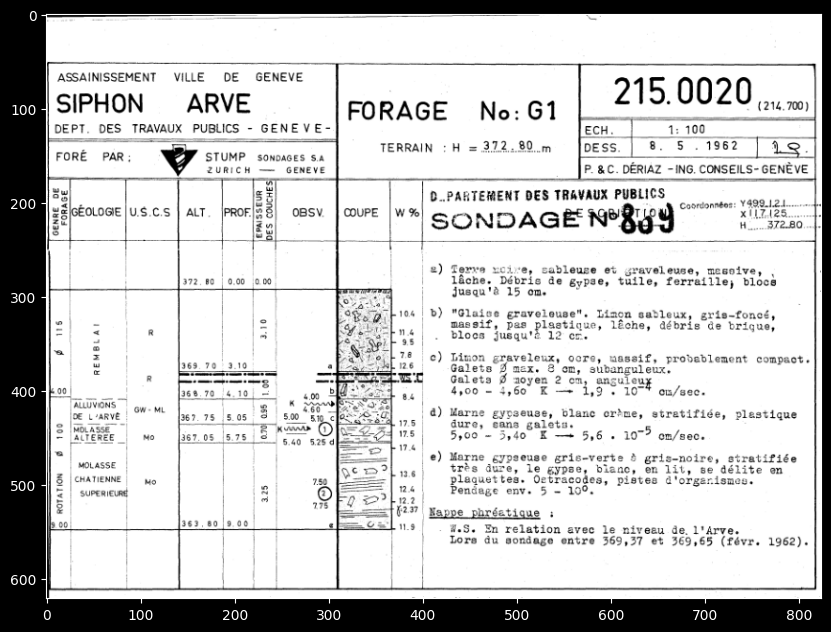

In [16]:
doc = fitz.open(os.path.join(input_directory, filename))
page = doc.load_page(0)
pix = page.get_pixmap()  # render page to an image

# plot the image
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
plt.imshow(np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n))
plt.show()

## Parse the text in the document

In [24]:
from stratigraphy.util.coordinate_extraction import CoordinateExtractor
from stratigraphy.util.drilling_method_extraction import DrillingMethodExtractor
from stratigraphy.util.extract_text import extract_text_lines
from stratigraphy.util.language_detection import detect_language_of_document

logger.info("Processing file: %s", os.path.join(input_directory, filename))

predictions = {}

with fitz.Document(os.path.join(input_directory, filename)) as doc:

    predictions[filename] = {}

    text_in_document = []
    for page in doc:
        text_in_document += extract_text_lines(page)
        page_number = page.number + 1  # page.number is 0-based

    # Find the language of the document
    language = detect_language_of_document(
        doc, matching_params["default_language"], matching_params["material_description"].keys()
    )
    predictions[filename]["language"] = language

    # Extract the coordinates of the borehole
    coordinate_extractor = CoordinateExtractor(doc)
    coordinates = coordinate_extractor.extract_coordinates()
    if coordinates:
        predictions[filename]["metadata"] = {"coordinates": coordinates.to_json()}
    else:
        predictions[filename]["metadata"] = {"coordinates": None}
    
    # Extract the drilling method
    drilling_method_extractor = DrillingMethodExtractor(doc)
    drilling_method = drilling_method_extractor.extract_drilling_method()
    predictions[filename]["metadata"]["drilling_method"] = drilling_method

In [21]:
drilling_method

TextLine(a) Terre moire, sableuse et graveleuse, massive,, Rect(408.5169982910156, 261.4489440917969, 755.3009643554688, 283.4329528808594))

In [25]:
text_in_document

[TextLine(ASSAINISSEMENT VILLE DE GENEVE, Rect(11.51609992980957, 57.5789794921875, 279.9411315917969, 78.18898010253906)),
 TextLine(SIPHON, Rect(10.744799613952637, 78.81095886230469, 102.76080322265625, 111.7869644165039)),
 TextLine(ARVE, Rect(149.26699829101562, 78.09197998046875, 217.34201049804688, 112.44197845458984)),
 TextLine(DEPT. DES TRAVAUX PUBLICS - GENEVE-, Rect(8.800950050354004, 112.39195251464844, 291.97894287109375, 131.62796020507812)),
 TextLine(FORÉ PAR, Rect(10.369799613952637, 140.75595092773438, 87.0498046875, 161.36595153808594)),
 TextLine(GEOLOGIE U.S.C.S, Rect(26.618799209594727, 202.43096923828125, 131.70199584960938, 218.91896057128906)),
 TextLine(STUMP, Rect(169.58599853515625, 144.00497436523438, 211.58599853515625, 160.4929656982422)),
 TextLine(ZURICH, Rect(171.0019989013672, 158.18896484375, 216.3260040283203, 174.6769561767578)),
 TextLine(ALT, Rect(148.67999267578125, 203.53895568847656, 168.85398864746094, 218.6529541015625)),
 TextLine(372.80, 

In [34]:
with fitz.Document(os.path.join(input_directory, filename)) as doc:
    for page in doc:
        text_in_doc = fitz.utils.get_text(page, "dict")
        for block in text_in_doc["blocks"]:
            for line in block["lines"]:
                for span in line["spans"]:
                    print(span["text"])

ASSAINISSEMENT VILLE DE GENEVE
SIPHON
ARVE
DEPT. DES TRAVAUX PUBLICS - GENEVE-
FORÉ PAR
GEOLOGIE
 U.S.C.S
STUMP
ZURICH
ALT
372.80
R
R
4.00
GW ML
MO
ALLUVIONS
DE L'ARVÉ
MOLASSE
ALTEREE
MO
MOLASSE
CHATIENNE
SUPERIEURE
369.70
368.70
367.75
367.05
363,80
SONDAGES S.A
GENEVE
PROF.
0.00
3.10
4.10
5.05
5.75
9.00
FORAGE No: G1
TERRAIN : H = 372.80 m
W %
0BSV.
COUPE
215. .0020
 (214.700)
ECH.
1:100
DESS.
19.
P. & C. DERIAZ - ING. CONSEILS-GENEVE
D PARTEMENT DES TRAVAUX PUBLICS
SONDAGE N°800
Coordonnées: Y499.12.1
X 117.125
H 372.80
a) Terre moire, sableuse et graveleuse, massive,
lâche. Débris de gypse, tuile, ferraille; blocs
jusqu'à 15 cm.
b) "Glaise graveleuse". Limon sableux, gris-foncé,
massif, pas plastique, lâche, débris de brique,
blocs jusqu'à 12 cm.
c) Limon graveleux, ocre, massif, probablement compact.
Galets 0 max. 8 cm, subanguleux.
Galets 0 moyen 2 cm, anguleux
4,00 - 4,60 K 1,9 10-4 cm/sec.
d) Marne gypseuse, blanc crème, stratifiée, plastique
dure, sans galets.
5,00 - 5,40 K 1 

ASSAINISSEMENT VILLE DE GENEVE
SIPHON
ARVE
DEPT. DES TRAVAUX PUBLICS - GENEVE-
FORÉ PAR
GEOLOGIE
 U.S.C.S
STUMP
ZURICH
ALT
372.80
R
R
4.00
GW ML
MO
ALLUVIONS
DE L'ARVÉ
MOLASSE
ALTEREE
MO
MOLASSE
CHATIENNE
SUPERIEURE
369.70
368.70
367.75
367.05
363,80
SONDAGES S.A
GENEVE
PROF.
0.00
3.10
4.10
5.05
5.75
9.00
FORAGE No: G1
TERRAIN : H = 372.80 m
W %
0BSV.
COUPE
215. .0020
 (214.700)
ECH.
1:100
DESS.
19.
P. & C. DERIAZ - ING. CONSEILS-GENEVE
D PARTEMENT DES TRAVAUX PUBLICS
SONDAGE N°800
Coordonnées: Y499.12.1
X 117.125
H 372.80
a) Terre moire, sableuse et graveleuse, massive,
lâche. Débris de gypse, tuile, ferraille; blocs
jusqu'à 15 cm.
b) "Glaise graveleuse". Limon sableux, gris-foncé,
massif, pas plastique, lâche, débris de brique,
blocs jusqu'à 12 cm.
c) Limon graveleux, ocre, massif, probablement compact.
Galets 0 max. 8 cm, subanguleux.
Galets 0 moyen 2 cm, anguleux
4,00 - 4,60 K 1,9 10-4 cm/sec.
d) Marne gypseuse, blanc crème, stratifiée, plastique
dure, sans galets.
5,00 - 5,40 K 1 

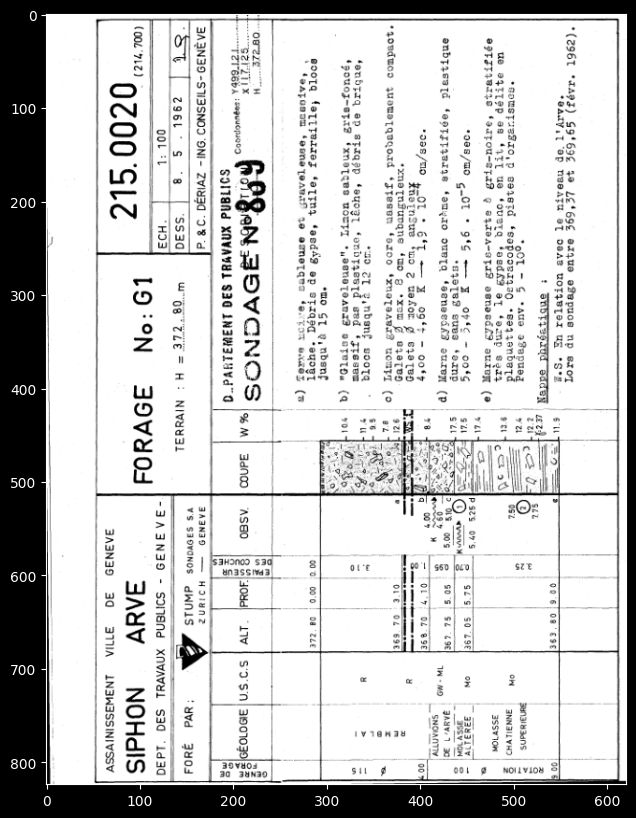

In [43]:
with fitz.Document(os.path.join(input_directory, filename)) as doc:
    for page in doc:
        page.set_rotation(270)
        text_in_doc = fitz.utils.get_text(page, "dict")
        for block in text_in_doc["blocks"]:
            for line in block["lines"]:
                for span in line["spans"]:
                    print(span["text"])

        pix = page.get_pixmap()  # render page to an image

        # plot the image
        import matplotlib.pyplot as plt
        import numpy as np

        plt.figure(figsize=(10, 10))
        plt.imshow(np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n))
        plt.show()

In [36]:
with fitz.Document(os.path.join(input_directory, filename)) as doc:
    # Select the page you want to extract text from
    page = doc[0]

    # Extract text as XML
    text = page.get_text("xml")

    # Process the XML to handle vertical text
    print(text)

<page id="page0" width="823.92" height="620.39999">
<block bbox="11.5161 57.57898 279.94114 78.18898">
<line bbox="11.5161 57.57898 279.94114 78.18898" wmode="0" dir="1 0">
<font name="Helvetica" size="15">
<char quad="11.5161 57.57898 21.5211 57.57898 11.5161 78.18898 21.5211 78.18898" x="11.5161" y="73.70398" bidi="0" color="#000000" c="A"/>
<char quad="21.521101 57.57898 31.5261 57.57898 21.521101 78.18898 31.5261 78.18898" x="21.521101" y="73.70398" bidi="0" color="#000000" c="S"/>
<char quad="31.526103 57.57898 41.5311 57.57898 31.526103 78.18898 41.5311 78.18898" x="31.526103" y="73.70398" bidi="0" color="#000000" c="S"/>
<char quad="41.531106 57.57898 51.536108 57.57898 41.531106 78.18898 51.536108 78.18898" x="41.531106" y="73.70398" bidi="0" color="#000000" c="A"/>
<char quad="51.536108 57.57898 55.706106 57.57898 51.536108 78.18898 55.706106 78.18898" x="51.536108" y="73.70398" bidi="0" color="#000000" c="I"/>
<char quad="55.70611 57.57898 66.53611 57.57898 55.70611 78.18898 

In [39]:
with fitz.Document(os.path.join(input_directory, filename)) as doc:

    # Select the page you want to extract text from
    page = doc[0]

    # Get text blocks along with their positions and rotations
    blocks = page.get_text("dict")["blocks"]

    for block in blocks:
        # Check if the block contains any rotated text
        for line in block["lines"]:
            for span in line["spans"]:
                # Regular text
                print("Text:", span["text"])

Text: ASSAINISSEMENT VILLE DE GENEVE
Text: SIPHON
Text: ARVE
Text: DEPT. DES TRAVAUX PUBLICS - GENEVE-
Text: FORÉ PAR
Text: GEOLOGIE
Text:  U.S.C.S
Text: STUMP
Text: ZURICH
Text: ALT
Text: 372.80
Text: R
Text: R
Text: 4.00
Text: GW ML
Text: MO
Text: ALLUVIONS
Text: DE L'ARVÉ
Text: MOLASSE
Text: ALTEREE
Text: MO
Text: MOLASSE
Text: CHATIENNE
Text: SUPERIEURE
Text: 369.70
Text: 368.70
Text: 367.75
Text: 367.05
Text: 363,80
Text: SONDAGES S.A
Text: GENEVE
Text: PROF.
Text: 0.00
Text: 3.10
Text: 4.10
Text: 5.05
Text: 5.75
Text: 9.00
Text: FORAGE No: G1
Text: TERRAIN : H = 372.80 m
Text: W %
Text: 0BSV.
Text: COUPE
Text: 215. .0020
Text:  (214.700)
Text: ECH.
Text: 1:100
Text: DESS.
Text: 19.
Text: P. & C. DERIAZ - ING. CONSEILS-GENEVE
Text: D PARTEMENT DES TRAVAUX PUBLICS
Text: SONDAGE N°800
Text: Coordonnées: Y499.12.1
Text: X 117.125
Text: H 372.80
Text: a) Terre moire, sableuse et graveleuse, massive,
Text: lâche. Débris de gypse, tuile, ferraille; blocs
Text: jusqu'à 15 cm.
Text: b) "G

In [40]:
with fitz.Document(os.path.join(input_directory, filename)) as doc:

    # Select the page you want to extract text from
    page = doc[0]

    # Rotate the page (e.g., 90 degrees)
    page.set_rotation(90)

    # Extract the text after rotation
    text = page.get_text("text")

    print(text)

ASSAINISSEMENT VILLE DE GENEVE
SIPHON
ARVE
DEPT. DES TRAVAUX PUBLICS - GENEVE-
FORÉ PAR
GEOLOGIE U.S.C.S
STUMP
ZURICH
ALT
372.80
R
R
4.00
GW ML
MO
ALLUVIONS
DE L'ARVÉ
MOLASSE
ALTEREE
MO
MOLASSE
CHATIENNE
SUPERIEURE
369.70
368.70
367.75
367.05
363,80
SONDAGES S.A
GENEVE
PROF.
0.00
3.10
4.10
5.05
5.75
9.00
FORAGE No: G1
TERRAIN : H = 372.80 m
W %
0BSV.
COUPE
215. .0020 (214.700)
ECH.
1:100
DESS.
19.
P. & C. DERIAZ - ING. CONSEILS-GENEVE
D PARTEMENT DES TRAVAUX PUBLICS
SONDAGE N°800
Coordonnées: Y499.12.1
X 117.125
H 372.80
a) Terre moire, sableuse et graveleuse, massive,
lâche. Débris de gypse, tuile, ferraille; blocs
jusqu'à 15 cm.
b) "Glaise graveleuse". Limon sableux, gris-foncé,
massif, pas plastique, lâche, débris de brique,
blocs jusqu'à 12 cm.
c) Limon graveleux, ocre, massif, probablement compact.
Galets 0 max. 8 cm, subanguleux.
Galets 0 moyen 2 cm, anguleux
4,00 - 4,60 K 1,9 10-4 cm/sec.
d) Marne gypseuse, blanc crème, stratifiée, plastique
dure, sans galets.
5,00 - 5,40 K 1 5,

# Draw the predictions

In [11]:
predictions

{'869.pdf': {'language': 'fr',
  'metadata': {'coordinates': None,
   'drilling_method': TextLine(a) Terre moire, sableuse et graveleuse, massive,, Rect(408.5169982910156, 261.4489440917969, 755.3009643554688, 283.4329528808594))}}}

In [12]:
from stratigraphy.util.draw import draw_predictions

os.makedirs(draw_directory, exist_ok=True)
draw_predictions(predictions, input_directory, draw_directory)

AttributeError: 'dict' object has no attribute 'pages'

# Other text extraction libraries

In [54]:
import fitz  # PyMuPDF
import pytesseract
from PIL import Image

# Open the PDF document
doc = fitz.open(os.path.join(input_directory, filename))

# Select the page
page = doc[0]

page.set_rotation(90)

# Render the page as an image
pix = page.get_pixmap()

# Convert to PIL Image
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

# Use Tesseract to extract text
text = pytesseract.image_to_string(img)

print(text)

ASSAINISSEMENT VILLE

SIPHON

DEPT. DES TRAVAUX PUBLICS - GENEVE-

ARVE

DE GENEVE

FoR

PAR

v

GENRE OE
roRAGe

JGEOLOGE |US.C.S

STUMP  sonoaces sa
2uRICH — GENEVE

FORAG

TERRAIN

215.0020... ..,

4s

P.&C. DERIAZ -ING, CONSEILS- GENEVE

E No:G1

H = 372.280.m

woOLASse
SUPERICURE

joer. 75 5.05:

jssros [6.78 8 ete sae

aa
(ord

W%
T

D_PABTEWENT DES TRAVAUX PUBLICS

SONDAGE N*BYGY ere

2) gma voive, cablouse et yraveleuse, meenive, ,
Ldche, Dévric de gypse, tuile, ferrailley blded
fusqu'e 150m.

Lizgn sableux, gris-fonos,

"Glaise gravel
» leche, débrie de brique,

massif, Das plas
qure 12

Iiuon graveleux, ocre, uasaif, probeblenent compact.
Galeto J acx. 8'on, atibangulenx.

Galets # aoyen 2 on, anculou;

4,00 - 4,60 K —~ 1,9. 10-* ou/sec.

Warne gypseuse, blanc ortne, stretifide, plestique
dure, cans galets. 5

5,00'~ 5,40 K —* 5,6 « 107? om/sec.

x euse gris-verte $ gris-noire, stretifiée
tres ‘Le gypee, bienc, on lit, se'aélite on
plaquettes. Octracoses, pistes d'orgenisnes.

In [57]:
import pdfplumber

with pdfplumber.open(os.path.join(input_directory, filename)) as pdf:
    page = pdf.pages[0]
    # text = page.extract_text()

    # Select the first page
    page = pdf.pages[0]
    
    # Extract characters with their positions
    chars = page.chars

    # Analyze the characters to find vertical text
    for char in chars:
        print(f"Character: {char['text']}, X0: {char['x0']}, X1: {char['x1']}, Y0: {char['top']}, Y1: {char['bottom']}, Font Size: {char['size']}")

print(text)

Character: A, X0: 11.5161, X1: 21.5211, Y0: 61.808989999999994, Y1: 76.80899, Font Size: 15.0
Character: S, X0: 21.5211, X1: 31.5261, Y0: 61.808989999999994, Y1: 76.80899, Font Size: 15.0
Character: S, X0: 31.5261, X1: 41.5311, Y0: 61.808989999999994, Y1: 76.80899, Font Size: 15.0
Character: A, X0: 41.5311, X1: 51.536100000000005, Y0: 61.808989999999994, Y1: 76.80899, Font Size: 15.0
Character: I, X0: 51.536100000000005, X1: 55.706100000000006, Y0: 61.808989999999994, Y1: 76.80899, Font Size: 15.0
Character: N, X0: 55.706100000000006, X1: 66.5361, Y0: 61.808989999999994, Y1: 76.80899, Font Size: 15.0
Character: I, X0: 66.5361, X1: 70.7061, Y0: 61.808989999999994, Y1: 76.80899, Font Size: 15.0
Character: S, X0: 70.7061, X1: 80.7111, Y0: 61.808989999999994, Y1: 76.80899, Font Size: 15.0
Character: S, X0: 80.7111, X1: 90.7161, Y0: 61.808989999999994, Y1: 76.80899, Font Size: 15.0
Character: E, X0: 90.7161, X1: 100.72109999999999, Y0: 61.808989999999994, Y1: 76.80899, Font Size: 15.0
Chara

In [59]:
import pdfplumber

def is_vertical_text(characters, threshold=2):
    # Sort characters by their x-coordinate (left to right)
    characters = sorted(characters, key=lambda c: c['x0'])
    
    vertical_text_blocks = []
    current_block = []
    
    for i, char in enumerate(characters):
        if i == 0:
            current_block.append(char)
            continue
        
        # Check if the current character is aligned vertically with the previous one
        if abs(char['x0'] - characters[i-1]['x0']) < threshold:
            current_block.append(char)
        else:
            if len(current_block) > 1:
                vertical_text_blocks.append(current_block)
            current_block = [char]
    
    if len(current_block) > 1:
        vertical_text_blocks.append(current_block)
    
    return vertical_text_blocks

# Open the PDF document
with pdfplumber.open(os.path.join(input_directory, filename)) as pdf:
    page = pdf.pages[0]
    chars = page.chars
    
    vertical_text_blocks = is_vertical_text(chars)
    
    for block in vertical_text_blocks:
        text = "".join([char["text"] for char in block])
        print(f"Vertical text block: {text}")

Vertical text block: 49
Vertical text block: D..FSA00
Vertical text block: 00EOS
Vertical text block: GIDPMAACRSPLMEOLESHTLTOOULAÉ UALEA.LPVLTH 'SAIR AEDIOINPOSSERER
Vertical text block: ESGNNIEEEAVIOESNISUEÉS
Vertical text block: ERR
Vertical text block: SE 
Vertical text block: NTU
Vertical text block: GR.
Vertical text block: SMW
Vertical text block: MMAR.RO OCEMV
Vertical text block: .LNSA
Vertical text block: UT
Vertical text block: 33 3X333
Vertical text block: VAA666667 
Vertical text block: L79P78I23
Vertical text block: LT.....,RU07787
Vertical text block: 8SLZ05050
Vertical text block: B0TEU
Vertical text block: VULR P
Vertical text block: 5459DI03MRIC......C7E00011OEP
Vertical text block: 05S050H0F
Vertical text block: . G
Vertical text block: -0
Vertical text block: S 
Vertical text block: .GE:0O
Vertical text block: NNE
Vertical text block: NEA55
Vertical text block: GG..K0EV40E0E
Vertical text block: 0BVNSE
Vertical text block: 4 4
Vertical text block:  S5EE.S.650.7V7.V.2